# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [6]:
# read in the json files
portfolio = pd.read_json('./portfolio.json', orient='records', lines=True)
profile = pd.read_json('./profile.json', orient='records', lines=True)
transcript = pd.read_json('./transcript.json', orient='records', lines=True)

In [7]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [8]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [11]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## EDA

In [19]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [20]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [21]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [22]:
profile.shape

(17000, 5)

In [23]:
profile.loc[profile['gender'].isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [24]:
profile.loc[profile['income'].isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [27]:
list(profile['id'].loc[profile['income'].isnull()]) == list(profile['id'].loc[profile['gender'].isnull()])

True

#### The 2175 missing values are the same across *income* and *gender*, which makes life a little bit easier. We will save these ids separately for now and will delete them from the other data:

In [7]:
profile_nans = profile.loc[profile['gender'].isnull()].reset_index(drop=True)

In [8]:
indices = profile.loc[profile['income'].isnull()].index

In [9]:
profile = profile.drop(indices, axis=0).reset_index(drop=True)
profile

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
14822,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [38]:
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [79]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

#### Slightly more men then women.

<BarContainer object of 3 artists>

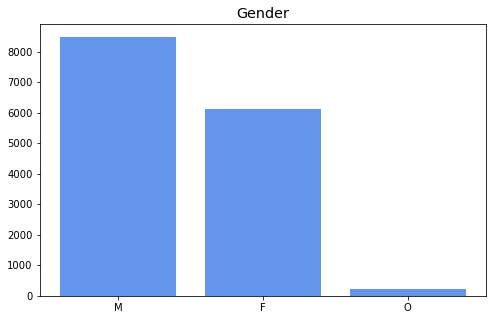

In [74]:
index = profile['gender'].value_counts().index
values = profile['gender'].value_counts()
plt.figure(figsize=(8,5))
plt.title('Gender', size="x-large")
plt.bar(index, values, color='#6495ED')

In [68]:
profile['age'].value_counts()[0:20]

58    408
53    372
51    363
59    359
54    359
57    353
52    351
55    350
56    342
63    338
60    333
49    321
62    318
67    317
64    311
61    309
48    288
66    284
50    284
65    280
Name: age, dtype: int64

#### Seems like a lot of registered users are in their 50s and 60s. Interesting.

<BarContainer object of 84 artists>

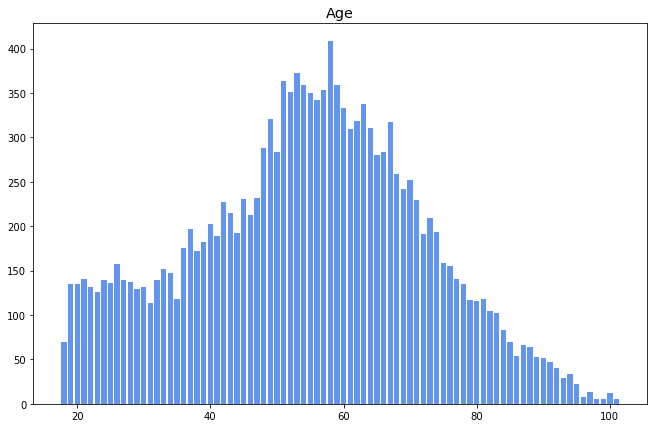

In [75]:
age = profile['age'].value_counts()
index = profile['age'].value_counts().index
plt.figure(figsize=(11,7))
plt.title('Age', size="x-large")
plt.bar(index, age, color='#6495ED')

#### I've noticed that the column *time* has a unit of days in *portfolio* and of hours since start of test in *transcript*. I think it would be better to convert hours to days as well, because we have to compare them with each other.

In [6]:
def hours_to_days(hours):
    days = ceil(hours/24)   #rounds up to the whole day, 
    return days             #f.e. one hour would lay in the 1st day, 26h in the second, etc.

In [7]:
transcript['time in days'] = [hours_to_days(hours) for hours in transcript["time"]]
transcript

,person,event,value,time,time in days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,30
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,30
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,30
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,30


In [33]:
profile['income'].value_counts()

73000.0     314
72000.0     297
71000.0     294
57000.0     288
53000.0     282
           ... 
116000.0     46
107000.0     45
112000.0     45
117000.0     32
120000.0     13
Name: income, Length: 91, dtype: int64

<BarContainer object of 91 artists>

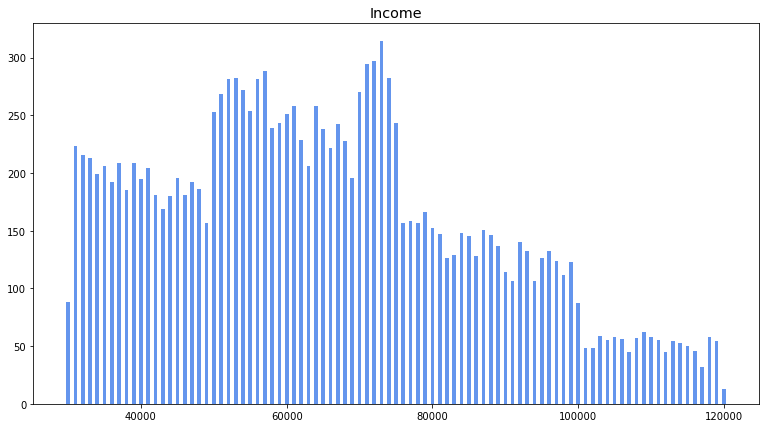

In [76]:
income = profile['income'].value_counts()
index = profile['income'].value_counts().index
plt.figure(figsize=(13,7))
plt.title('Income', size="x-large")
plt.bar(index, income, color='#6495ED', width=500)

In [91]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [96]:
transcript['person'].value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
                                    ..
afd41b230f924f9ca8f5ed6249616114     2
3a4e53046c544134bb1e7782248631d1     2
e63e42480aae4ede9f07cac49c8c3f78     2
7ecfc592171f4844bdc05bdbb48d3847     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

#### We have to delete ids from NaNs:

In [77]:
to_drop = list(profile_nans['id'])

In [78]:
indizes = []
for i in range(len(transcript['person'])):
    if transcript["person"].iloc[i] in to_drop:
        indizes.append(i)
len(indizes)

33772

In [79]:
transcript_cut = transcript.drop(indizes, axis=0).reset_index(drop=True)
transcript_cut

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
...,...,...,...,...
272757,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
272758,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
272759,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
272760,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714


In [68]:
transcript_cut['person'].value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
                                    ..
22617705eec442e0b7b43e5c5f56fb17     2
fccc9279ba56411f80ffe8ce7e0935cd     2
e63e42480aae4ede9f07cac49c8c3f78     2
cae5e211053f4121a389a7da4d631f7f     2
3045af4e98794a04a5542d3eac939b1f     2
Name: person, Length: 14825, dtype: int64

At least we do not seem to have lost the top active customers.

In [11]:
received = transcript_cut.loc[transcript_cut["event"]=="offer received"]
received

,person,event,value,time,time in days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
...,...,...,...,...,...
229121,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24
229122,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,24
229123,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,24
229124,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24


In [70]:
received["person"].value_counts()

7a3f7b744de042fbadf2fe7f72619bda    6
3add99f440924505bead6fcc818445ba    6
6eea5ba7675c40819cf15dbeacc8897f    6
99da812a6cf9401ea5df979119e4f507    6
b8cdaf04fcf34321b1e10736f616541d    6
                                   ..
d15a2f0fea174679a01d2dd889cf0d10    1
f6f3412fccea4ca7a15724586ef0e792    1
165faf21d18549ed802e14b605f6db08    1
cae5e211053f4121a389a7da4d631f7f    1
9a3f45cf29ef428b932492c7a5d6ac52    1
Name: person, Length: 14820, dtype: int64

#### There were 14820 unique persons who had received at least one offer.

In [12]:
viewed = transcript_cut.loc[transcript_cut["event"]=="offer viewed"] 
viewed

,person,event,value,time,time in days
11023,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0
11024,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0
11025,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
11026,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0
11028,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0
...,...,...,...,...,...
272672,ec1761735b034ae8874bc979f0cd5862,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,30
272687,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,30
272717,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,30
272724,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,30


In [72]:
viewed["person"].value_counts()

389bc3fa690240e798340f5a15918d5c    6
3b899227f99e466a8d77b4d7519bde11    6
d810b7f740fc4b2bbe947b8149cf5457    6
7e20102a702848b18c100b8695f5d21a    6
9bfeb65da0cf4bca95da96ef8684ace4    6
                                   ..
9f912a6711234b4db8a35a0056bc930e    1
169ad543fdaa433a820d84502c32a826    1
e12aeaf2d47d42479ea1c4ac3d8286c6    1
2481f1fcfbcb4b288e5a03af02d95373    1
e3728b309d2a4dac904aa3286a8cb2ca    1
Name: person, Length: 14675, dtype: int64

#### Only 14675 out of 14820 had also opened the offer. 145 persons had not.

In [73]:
viewed.shape[0]/received.shape[0]

0.7497631614562187

#### Almost in 75% of cases the customers who had received the offer also viewed it. How many completed the offer afterwards? 

In [13]:
completed = transcript_cut.loc[transcript_cut["event"]=="offer completed"]  
completed

,person,event,value,time,time in days
11031,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,0
11042,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,0
11048,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,0
11056,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,0
11060,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,0
...,...,...,...,...,...
272693,f3e801caeafe4899b3b989b586e74ac7,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,714,30
272705,452cdae2c68e4732a4177d3929562690,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,30
272710,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,30
272739,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,30


In [75]:
ids_completed = list(completed["person"])
ids_viewed_and_completed = []

for person in viewed["person"]:
    if person in ids_completed:
        ids_viewed_and_completed.append(person)
len(ids_viewed_and_completed)

41932

We obviously have some duplicates.

In [76]:
unique_ids_viewed_and_completed = list(set(ids_viewed_and_completed))
len(unique_ids_viewed_and_completed)

11916

#### So, obviously not all of 14675 persons actually completed the offer after opening it. Moreover, among these 11916 persons there might also be some who completed an offer without knowing it before they had opened an offer. We have to differentiate.

For instance:

In [31]:
unique_ids_viewed_and_completed[0]

'ee9227fb8452414c91f06eb25c29d474'

In [77]:
transcript_cut.loc[transcript_cut['person']==unique_ids_viewed_and_completed[0]]

,person,event,value,time,time in days
6078,ee9227fb8452414c91f06eb25c29d474,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
92011,ee9227fb8452414c91f06eb25c29d474,transaction,{'amount': 18.15},288,12
104828,ee9227fb8452414c91f06eb25c29d474,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},336,14
140107,ee9227fb8452414c91f06eb25c29d474,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},408,17
172761,ee9227fb8452414c91f06eb25c29d474,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},474,20
185423,ee9227fb8452414c91f06eb25c29d474,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},504,21
210162,ee9227fb8452414c91f06eb25c29d474,transaction,{'amount': 14.29},546,23
210163,ee9227fb8452414c91f06eb25c29d474,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,546,23
224078,ee9227fb8452414c91f06eb25c29d474,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},576,24
245290,ee9227fb8452414c91f06eb25c29d474,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},606,26


Here we see that this person had received 5 offers and had completed just one of them, however she or he had made 3 transactions, not just one.

In [80]:
print("First opened offer")
portfolio.loc[portfolio["id"]=="5a8bc65990b245e5a138643cd4eb9837"]

First opened offer


,reward,channels,difficulty,duration,offer_type,id
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


In [81]:
print("Second opened offer")
portfolio.loc[portfolio["id"]=="5a8bc65990b245e5a138643cd4eb9837"]

Second opened offer


,reward,channels,difficulty,duration,offer_type,id
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


In [83]:
print("Unopened offer")
portfolio.loc[portfolio["id"]=="9b98b8c7a33c4b65b9aebfe6a799e6d9"]

Unopened offer


,reward,channels,difficulty,duration,offer_type,id
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9


The first viewed offer was an advertisement with a duration of three days. The second and the last viewed offer was also an advertisement. Both transaction amounts are way higher than for just a drink, therefore I don't think that the customer was influenced by an offer he or she saw. At the same time this customer received 4 BOGO offers he or she never opened, but completed one of them nethertheless.

### Blueprint

a classifier for **ten classes**: 

- BOGO duration 7, difficulty 5, 
- BOGO duration 7, difficulty 10, 
- BOGO duration 5, difficulty 10,
- BOGO duration 5, difficulty 5, 
- info duration 3,
- info duration 4,
- discount duration 7, difficulty 7,
- discount duration 7, difficulty 10,
- discount duration 10, difficulty 10,
- discount duration 10, difficulty 20


**feuatures**:
gender, age, income, become_member_on, received_offer 0 to 9 respectively

**targets** (to generate):
0 to 9 respectively


*portfolio* as a look-up:

In [84]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## Feature engineering

In [80]:
transcript_cut['index'] = transcript_cut.index
transcript_cut

,person,event,value,time,index
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,2
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,4
...,...,...,...,...,...
272757,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,272757
272758,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,272758
272759,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,272759
272760,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,272760


Order completed because it was viewed:

In [81]:
viewed = transcript_cut.loc[transcript_cut["event"]=="offer viewed"] 
viewed

,person,event,value,time,index
11023,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,11023
11024,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,11024
11025,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,11025
11026,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,11026
11028,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,11028
...,...,...,...,...,...
272672,ec1761735b034ae8874bc979f0cd5862,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,272672
272687,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,272687
272717,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,272717
272724,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,272724


In [82]:
viewed.loc[viewed["person"]==viewed["person"].iloc[0]]

,person,event,value,time,index
11023,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,11023
68508,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},192,68508
117963,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},354,117963
159883,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},438,159883
190410,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},504,190410
235952,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},588,235952


In [94]:
profile

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
14822,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


Create an empty table which will be filled out and used later as targets:

In [66]:
empty = np.zeros(14825)

offers_completed = pd.DataFrame(zip(profile['id'], empty, empty, empty, empty, empty, empty, empty, empty, empty, empty),
                               columns=['id', '0', '1', '2', '3', '4', '5', '6', '7', '8','9'])

In [67]:
offers_completed

,id,0,1,2,3,4,5,6,7,8,9
0,0610b486422d4921ae7d2bf64640c50b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,389bc3fa690240e798340f5a15918d5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14820,6d5f3a774f3d4714ab0c092238f3a1d7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14821,2cb4f97358b841b9a9773a7aa05a9d77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14822,01d26f638c274aa0b965d24cefe3183f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14823,9dc1421481194dcd9400aec7c9ae6366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
offers_id_dict = portfolio['id'].to_dict()

In [24]:
offers_id_dict

{0: 'ae264e3637204a6fb9bb56bc8210ddfd',
 1: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 2: '3f207df678b143eea3cee63160fa8bed',
 3: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 4: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 5: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 6: 'fafdcd668e3743c1bb461111dcafc2a4',
 7: '5a8bc65990b245e5a138643cd4eb9837',
 8: 'f19421c1d4aa40978ebb69ca19b0e20d',
 9: '2906b810c7d4411798c6938adc9daaa5'}

In [25]:
offers_id_dict = {v: k for k, v in offers_id_dict.items()}
offers_id_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 0,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 1,
 '3f207df678b143eea3cee63160fa8bed': 2,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 3,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 4,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 5,
 'fafdcd668e3743c1bb461111dcafc2a4': 6,
 '5a8bc65990b245e5a138643cd4eb9837': 7,
 'f19421c1d4aa40978ebb69ca19b0e20d': 8,
 '2906b810c7d4411798c6938adc9daaa5': 9}

In [117]:
viewed["value"].iloc[0]["offer id"]

'f19421c1d4aa40978ebb69ca19b0e20d'

In [71]:
def how_many_days(offer_id):
    days_to_complete = portfolio['duration'].loc[portfolio['id']==offer_id]
    return int(days_to_complete)

In [76]:
for person in offers_completed['id']:
    viewed_part = viewed.loc[viewed["person"]==person]
    completed_part = completed.loc[completed["person"]==person]
    transcript_cut_part = transcript_cut.loc[transcript_cut["person"]==person]
    
    for l in range(viewed_part.shape[0]):
        id_value = viewed_part['value'].iloc[l]
        offer_id = id_value["offer id"]
        days_to_complete = how_many_days(offer_id)
        viewed_time = viewed_part['time in days'].iloc[l]
        column = offers_id_dict[offer_id]
        
        if column == 2 or column == 7:
            index_list = list(transcript_cut_part.index)
            where_to_start = index_list.index(viewed_part['index'].iloc[l])
            for i in range(where_to_start+1, transcript_cut_part.shape[0]):
                if transcript_cut_part["event"].iloc[i]=="transaction":
                    difference = transcript_cut_part["time in days"].iloc[i]-viewed_time
                    if difference <= days_to_complete and difference >=0:
                        offers_completed[str(column)].loc[offers_completed['id']==person] +=1

        else:    
            for i in range(completed_part.shape[0]):
                if completed_part['value'].iloc[i]["offer_id"] == offer_id:
                    difference = completed_part['time in days'].iloc[i]-viewed_time
                    if difference <= days_to_complete and difference >=0:
                        offers_completed[str(column)].loc[offers_completed['id']==person] +=1

In [77]:
offers_completed

,id,0,1,2,3,4,5,6,7,8,9
0,0610b486422d4921ae7d2bf64640c50b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,389bc3fa690240e798340f5a15918d5c,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0
4,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14820,6d5f3a774f3d4714ab0c092238f3a1d7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14821,2cb4f97358b841b9a9773a7aa05a9d77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14822,01d26f638c274aa0b965d24cefe3183f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
14823,9dc1421481194dcd9400aec7c9ae6366,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
offers_completed.to_csv('./offers_completed', index=False)

In [15]:
offers_completed = pd.read_csv("./offers_completed")

In [100]:
offers_completed.describe()

,0,1,2,3,4,5,6,7,8,9
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.197437,0.200742,0.319663,0.156223,0.101720,0.307116,0.333693,0.494368,0.247555,0.156695
std,0.503435,0.489818,0.952038,0.443076,0.368465,0.607267,0.664121,1.137764,0.527283,0.447831
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,6.000000,6.000000,13.000000,7.000000,5.000000,8.000000,7.000000,18.000000,4.000000,6.000000


In [84]:
offers_completed.loc[offers_completed["7"]==18]

,id,0,1,2,3,4,5,6,7,8,9
10183,23d67a23296a485781e69c109a10a1cf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0


In [18]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [85]:
transcript_cut.loc[transcript_cut['person']=="23d67a23296a485781e69c109a10a1cf"]

,person,event,value,time,time in days,index
7499,23d67a23296a485781e69c109a10a1cf,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0,7499
34690,23d67a23296a485781e69c109a10a1cf,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},84,4,34690
41165,23d67a23296a485781e69c109a10a1cf,transaction,{'amount': 1.53},120,5,41165
42927,23d67a23296a485781e69c109a10a1cf,transaction,{'amount': 0.72},132,6,42927
54067,23d67a23296a485781e69c109a10a1cf,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,7,54067
63175,23d67a23296a485781e69c109a10a1cf,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},174,8,63175
69874,23d67a23296a485781e69c109a10a1cf,transaction,{'amount': 4.97},192,8,69874
71744,23d67a23296a485781e69c109a10a1cf,transaction,{'amount': 0.9500000000000001},198,9,71744
80088,23d67a23296a485781e69c109a10a1cf,transaction,{'amount': 1.2},228,10,80088
81515,23d67a23296a485781e69c109a10a1cf,transaction,{'amount': 1.4},234,10,81515


In [83]:
profile2 = profile.copy()
profile2

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
14822,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [84]:
profile2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


In [85]:
gender = {'M':0, 'F':1, 'O':2}

def categorize(char):
    category = gender[char]
    return category

profile2['gender'] = list(map(categorize, profile2['gender']))

In [87]:
profile2['gender'] = profile2['gender'].astype("category")

In [86]:
profile2['became_member_on'] = profile2['became_member_on'].astype("string")
profile2['became_member_on'] = pd.to_datetime(profile2['became_member_on'])
profile2

,gender,age,id,became_member_on,income
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0
...,...,...,...,...,...
14820,1,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
14821,0,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
14822,0,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
14823,1,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


In [88]:
profile2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  category      
 1   age               14825 non-null  int64         
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 478.0+ KB


In [89]:
profile2.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [90]:
age_scaler = StandardScaler()
income_scaler = StandardScaler()

In [91]:
age = np.array(profile2["age"]).reshape(-1,1)
profile2["age"] = age_scaler.fit_transform(age)

In [92]:
income = np.array(profile2["income"]).reshape(-1,1)
profile2["income"] = income_scaler.fit_transform(income)

In [93]:
profile2.describe()

,age,income
count,1.482500e+04,1.482500e+04
mean,-1.336124e-16,-1.022154e-16
std,1.000034e+00,1.000034e+00
min,-2.093613e+00,-1.639304e+00
25%,-7.129632e-01,-7.595758e-01
50%,3.488876e-02,-6.505322e-02
75%,6.676866e-01,6.757708e-01
max,2.681134e+00,2.527831e+00


In [94]:
profile2

,gender,age,id,became_member_on,income
0,1,0.034889,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2.157419
1,1,1.185430,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,1.601801
2,0,0.782741,e2127556f4f64592b11af22de27a7932,2018-04-26,0.212756
3,0,0.610160,389bc3fa690240e798340f5a15918d5c,2018-02-09,-0.574370
4,0,0.207470,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,-0.666973
...,...,...,...,...,...
14820,1,-0.540382,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,-0.528068
14821,0,0.380051,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,0.305359
14822,0,-0.310274,01d26f638c274aa0b965d24cefe3183f,2017-01-26,0.351660
14823,1,1.645647,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,-0.713274


#### Looks like the data is ready to roll!

In [207]:
profile2.to_csv('./profile2', index=False)

In [16]:
profile2 = pd.read_csv('./profile2')

In [89]:
data = profile2.merge(offers_completed)
data

,gender,age,id,became_member_on,income,0,1,2,3,4,5,6,7,8,9
0,1,0.034889,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2.157419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.185430,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,1.601801,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0,0.782741,e2127556f4f64592b11af22de27a7932,2018-04-26,0.212756,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0.610160,389bc3fa690240e798340f5a15918d5c,2018-02-09,-0.574370,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0
4,0,0.207470,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,-0.666973,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,1,-0.540382,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,-0.528068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14821,0,0.380051,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,0.305359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14822,0,-0.310274,01d26f638c274aa0b965d24cefe3183f,2017-01-26,0.351660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
14823,1,1.645647,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,-0.713274,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  category      
 1   age               14825 non-null  float64       
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   0                 14825 non-null  float64       
 6   1                 14825 non-null  float64       
 7   2                 14825 non-null  float64       
 8   3                 14825 non-null  float64       
 9   4                 14825 non-null  float64       
 10  5                 14825 non-null  float64       
 11  6                 14825 non-null  float64       
 12  7                 14825 non-null  float64       
 13  8                 14825 non-null  float64       
 14  9                 1482

In [74]:
data.to_csv('./processed_data', index=False)

#### One more feature to engineer though (10 features, aktually):

In [17]:
data = pd.read_csv('./processed_data')
data

,gender,age,id,became_member_on,income,0,1,2,3,4,5,6,7,8,9
0,F,0.034889,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2.157419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,F,1.185430,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,1.601801,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
2,M,0.782741,e2127556f4f64592b11af22de27a7932,2018-04-26,0.212756,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,M,0.610160,389bc3fa690240e798340f5a15918d5c,2018-02-09,-0.574370,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0
4,M,0.207470,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,-0.666973,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,F,-0.540382,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,-0.528068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14821,M,0.380051,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,0.305359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14822,M,-0.310274,01d26f638c274aa0b965d24cefe3183f,2017-01-26,0.351660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
14823,F,1.645647,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,-0.713274,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
for i in range(10):
    data['received_'+str(i)] = np.zeros(14825)
data

,gender,age,id,became_member_on,income,0,1,2,3,4,...,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9
0,1,0.034889,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2.157419,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.185430,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,1.601801,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.782741,e2127556f4f64592b11af22de27a7932,2018-04-26,0.212756,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.610160,389bc3fa690240e798340f5a15918d5c,2018-02-09,-0.574370,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.207470,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,-0.666973,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,1,-0.540382,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,-0.528068,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14821,0,0.380051,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,0.305359,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14822,0,-0.310274,01d26f638c274aa0b965d24cefe3183f,2017-01-26,0.351660,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14823,1,1.645647,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,-0.713274,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
received

,person,event,value,time,time in days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
...,...,...,...,...,...
229121,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24
229122,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,24
229123,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,24
229124,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24


In [92]:
for i in range(data.shape[0]) :
    person = data["id"].iloc[i]
    received_part = received.loc[received['person']==person]
    for l in range(received_part.shape[0]):
        if received_part["event"].iloc[l] == "offer received":
            number = offers_id_dict[received_part["value"].iloc[l]['offer id']]
            data['received_'+str(number)].iloc[i] += 1

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [93]:
data

,gender,age,id,became_member_on,income,0,1,2,3,4,...,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9
0,1,0.034889,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2.157419,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.185430,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,1.601801,1.0,0.0,0.0,3.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0,0.782741,e2127556f4f64592b11af22de27a7932,2018-04-26,0.212756,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,0.610160,389bc3fa690240e798340f5a15918d5c,2018-02-09,-0.574370,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,1.0
4,0,0.207470,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,-0.666973,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,1,-0.540382,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,-0.528068,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
14821,0,0.380051,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,0.305359,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
14822,0,-0.310274,01d26f638c274aa0b965d24cefe3183f,2017-01-26,0.351660,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
14823,1,1.645647,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,-0.713274,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
data.describe()

,age,income,0,1,2,3,4,5,6,7,...,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9
count,1.482500e+04,1.482500e+04,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,...,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,-1.378699e-16,-1.037506e-16,0.197437,0.200742,0.319663,0.156223,0.101720,0.307116,0.333693,0.494368,...,0.450793,0.444722,0.449039,0.450927,0.453693,0.448904,0.448702,0.448094,0.443575,0.447285
std,1.000034e+00,1.000034e+00,0.503435,0.489818,0.952038,0.443076,0.368465,0.607267,0.664121,1.137764,...,0.644540,0.638578,0.644926,0.646222,0.646009,0.647213,0.641123,0.644956,0.644262,0.647604
min,-2.093613e+00,-1.639304e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.129632e-01,-7.595758e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.488876e-02,-6.505322e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.676866e-01,6.757708e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.681134e+00,2.527831e+00,6.000000,6.000000,13.000000,7.000000,5.000000,8.000000,7.000000,18.000000,...,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000


In [95]:
for i in range(10):
    scaler = StandardScaler()
    received_n = np.array(data["received_"+str(i)]).reshape(-1,1)
    data["received_"+str(i)] = scaler.fit_transform(received_n)
data.describe()

,age,income,0,1,2,3,4,5,6,7,...,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9
count,1.482500e+04,1.482500e+04,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,...,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04
mean,-1.378699e-16,-1.037506e-16,0.197437,0.200742,0.319663,0.156223,0.101720,0.307116,0.333693,0.494368,...,-6.671523e-16,5.307353e-17,-4.623620e-16,-3.747873e-16,-1.690085e-16,1.429248e-16,-1.204103e-15,2.152552e-15,-9.899520e-17,-2.394936e-17
std,1.000034e+00,1.000034e+00,0.503435,0.489818,0.952038,0.443076,0.368465,0.607267,0.664121,1.137764,...,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00
min,-2.093613e+00,-1.639304e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.994261e-01,-6.964491e-01,-6.962870e-01,-6.978136e-01,-7.023254e-01,-6.936188e-01,-6.998917e-01,-6.947911e-01,-6.885242e-01,-6.906999e-01
25%,-7.129632e-01,-7.595758e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.994261e-01,-6.964491e-01,-6.962870e-01,-6.978136e-01,-7.023254e-01,-6.936188e-01,-6.998917e-01,-6.947911e-01,-6.885242e-01,-6.906999e-01
50%,3.488876e-02,-6.505322e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.994261e-01,-6.964491e-01,-6.962870e-01,-6.978136e-01,-7.023254e-01,-6.936188e-01,-6.998917e-01,-6.947911e-01,-6.885242e-01,-6.906999e-01
75%,6.676866e-01,6.757708e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,8.521214e-01,8.695843e-01,8.543296e-01,8.496938e-01,8.456934e-01,8.515199e-01,8.599240e-01,8.557551e-01,8.636916e-01,8.535055e-01
max,2.681134e+00,2.527831e+00,6.000000,6.000000,13.000000,7.000000,5.000000,8.000000,7.000000,18.000000,...,5.506764e+00,5.567684e+00,5.506180e+00,5.492216e+00,7.037769e+00,5.486936e+00,5.539371e+00,7.057940e+00,7.072555e+00,5.486122e+00


Now we're talking.

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  category      
 1   age               14825 non-null  float64       
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   0                 14825 non-null  float64       
 6   1                 14825 non-null  float64       
 7   2                 14825 non-null  float64       
 8   3                 14825 non-null  float64       
 9   4                 14825 non-null  float64       
 10  5                 14825 non-null  float64       
 11  6                 14825 non-null  float64       
 12  7                 14825 non-null  float64       
 13  8                 14825 non-null  float64       
 14  9                 1482

In [97]:
data.to_csv('./processed_data', index=False)

In [98]:
X = data[['gender', 'age', 'became_member_on', 'income', 'received_0', 'received_1', 'received_2', 'received_3', 'received_4', 'received_5', 'received_6', 'received_7', 'received_8', 'received_9']]
y = data[['0', '1', '2', '3', '4', '5', '6', '7', '8','9']]


In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  category      
 1   age               14825 non-null  float64       
 2   became_member_on  14825 non-null  datetime64[ns]
 3   income            14825 non-null  float64       
 4   received_0        14825 non-null  float64       
 5   received_1        14825 non-null  float64       
 6   received_2        14825 non-null  float64       
 7   received_3        14825 non-null  float64       
 8   received_4        14825 non-null  float64       
 9   received_5        14825 non-null  float64       
 10  received_6        14825 non-null  float64       
 11  received_7        14825 non-null  float64       
 12  received_8        14825 non-null  float64       
 13  received_9        14825 non-null  float64       
dtypes: category(1), dateti

In [103]:
y

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
14820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
14823,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
X.to_csv('X', index=False)
y.to_csv('y', index=False)

### Training

In [2]:
X = pd.read_csv('X')
y = pd.read_csv('y')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

#### Later I discovered that Gradient Boosting won't accept *datetime* as an input, so we need a workaround:

In [107]:
data['became_member_on'] = pd.to_numeric(data['became_member_on'])
data

,gender,age,id,became_member_on,income,0,1,2,3,4,...,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9
0,1,0.034889,0610b486422d4921ae7d2bf64640c50b,1500076800000000000,2.157419,0.0,0.0,0.0,0.0,0.0,...,-0.699426,-0.696449,0.854330,0.849694,-0.702325,-0.693619,-0.699892,-0.694791,-0.688524,-0.690700
1,1,1.185430,78afa995795e4d85b5d9ceeca43f5fef,1494288000000000000,1.601801,1.0,0.0,0.0,3.0,0.0,...,0.852121,-0.696449,-0.696287,0.849694,-0.702325,-0.693619,-0.699892,0.855755,0.863692,-0.690700
2,0,0.782741,e2127556f4f64592b11af22de27a7932,1524700800000000000,0.212756,0.0,0.0,0.0,1.0,0.0,...,-0.699426,-0.696449,0.854330,0.849694,-0.702325,-0.693619,0.859924,-0.694791,-0.688524,0.853505
3,0,0.610160,389bc3fa690240e798340f5a15918d5c,1518134400000000000,-0.574370,0.0,0.0,0.0,1.0,0.0,...,-0.699426,-0.696449,-0.696287,2.397201,-0.702325,-0.693619,0.859924,-0.694791,2.415907,0.853505
4,0,0.207470,2eeac8d8feae4a8cad5a6af0499a211d,1510358400000000000,-0.666973,0.0,0.0,0.0,0.0,0.0,...,-0.699426,-0.696449,0.854330,-0.697814,-0.702325,0.851520,0.859924,-0.694791,-0.688524,-0.690700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,1,-0.540382,6d5f3a774f3d4714ab0c092238f3a1d7,1528070400000000000,-0.528068,0.0,0.0,0.0,0.0,0.0,...,-0.699426,0.869584,-0.696287,-0.697814,-0.702325,0.851520,-0.699892,0.855755,-0.688524,-0.690700
14821,0,0.380051,2cb4f97358b841b9a9773a7aa05a9d77,1531440000000000000,0.305359,0.0,0.0,0.0,0.0,0.0,...,-0.699426,-0.696449,0.854330,0.849694,-0.702325,-0.693619,-0.699892,0.855755,-0.688524,-0.690700
14822,0,-0.310274,01d26f638c274aa0b965d24cefe3183f,1485388800000000000,0.351660,0.0,0.0,0.0,0.0,0.0,...,-0.699426,-0.696449,0.854330,-0.697814,0.845693,-0.693619,-0.699892,0.855755,-0.688524,-0.690700
14823,1,1.645647,9dc1421481194dcd9400aec7c9ae6366,1457308800000000000,-0.713274,0.0,1.0,0.0,0.0,0.0,...,0.852121,0.869584,-0.696287,0.849694,-0.702325,-0.693619,-0.699892,-0.694791,-0.688524,-0.690700


In [112]:
scaler = StandardScaler()
data['became_member_on'] = scaler.fit_transform(np.array(data['became_member_on']).reshape(-1,1))
data.describe()

,age,became_member_on,income,0,1,2,3,4,5,6,...,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9
count,1.482500e+04,1.482500e+04,1.482500e+04,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,...,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04,1.482500e+04
mean,-1.378699e-16,-1.670940e-15,-1.037506e-16,0.197437,0.200742,0.319663,0.156223,0.101720,0.307116,0.333693,...,-6.671523e-16,5.307353e-17,-4.623620e-16,-3.747873e-16,-1.690085e-16,1.429248e-16,-1.204103e-15,2.152552e-15,-9.899520e-17,-2.394936e-17
std,1.000034e+00,1.000034e+00,1.000034e+00,0.503435,0.489818,0.952038,0.443076,0.368465,0.607267,0.664121,...,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00
min,-2.093613e+00,-3.102454e+00,-1.639304e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.994261e-01,-6.964491e-01,-6.962870e-01,-6.978136e-01,-7.023254e-01,-6.936188e-01,-6.998917e-01,-6.947911e-01,-6.885242e-01,-6.906999e-01
25%,-7.129632e-01,-6.548829e-01,-7.595758e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.994261e-01,-6.964491e-01,-6.962870e-01,-6.978136e-01,-7.023254e-01,-6.936188e-01,-6.998917e-01,-6.947911e-01,-6.885242e-01,-6.906999e-01
50%,3.488876e-02,3.923724e-01,-6.505322e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.994261e-01,-6.964491e-01,-6.962870e-01,-6.978136e-01,-7.023254e-01,-6.936188e-01,-6.998917e-01,-6.947911e-01,-6.885242e-01,-6.906999e-01
75%,6.676866e-01,7.502045e-01,6.757708e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,8.521214e-01,8.695843e-01,8.543296e-01,8.496938e-01,8.456934e-01,8.515199e-01,8.599240e-01,8.557551e-01,8.636916e-01,8.535055e-01
max,2.681134e+00,1.246398e+00,2.527831e+00,6.000000,6.000000,13.000000,7.000000,5.000000,8.000000,7.000000,...,5.506764e+00,5.567684e+00,5.506180e+00,5.492216e+00,7.037769e+00,5.486936e+00,5.539371e+00,7.057940e+00,7.072555e+00,5.486122e+00


In [113]:
X = data[['gender', 'age', 'became_member_on', 'income', 'received_0', 'received_1', 'received_2', 'received_3', 'received_4', 'received_5', 'received_6', 'received_7', 'received_8', 'received_9']]

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

### Fit the classifier and predict

In [24]:
gbr = GradientBoostingRegressor(random_state=13)

regressor = MultiOutputRegressor(gbr)
regressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=13))

In [79]:
gbr.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 13,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [25]:
predictions = regressor.predict(X_test)

In [26]:
preds_rounded = predictions.round() #because we can't have 3,0323 transactions. Just 3.

### Evaluate

In [8]:
def multi_rmse(y_true, y_pred):
    predictions_T = np.transpose(y_pred)
    scores = []
    for column in y_true.columns:
        rmse = mean_squared_error(y_true[column], predictions_T[int(column)], squared=False)
        scores.append(rmse)
    return scores


def multi_r2(y_true, y_pred):
    predictions_T = np.transpose(y_pred)
    scores = []
    for column in y_true.columns:
        r2 = r2_score(y_true[column], predictions_T[int(column)])
        scores.append(r2)
    return scores

In [13]:
def multi_rmse_customer(y_true, y_pred):
    scores = []
    for row in range(y_true.shape[0]):
        rmse = mean_squared_error(y_true.iloc[row], y_pred[row], squared=False)
        scores.append(rmse)
    return scores


def multi_r2_customer(y_true, y_pred):
    scores = []
    for row in range(y_true.shape[0]):
        r2 = r2_score(y_true.iloc[row], y_pred[row])
        scores.append(r2)
    return scores

In [168]:
rmse = multi_rmse(y_test, preds_rounded)
rmse

[0.4337420483782445,
 0.3699793145426928,
 0.8272988975862375,
 0.38340491088556305,
 0.37270312540924305,
 0.4031233419940082,
 0.40728365180503706,
 0.8054098942617858,
 0.4081106245383626,
 0.4391495489756028]

In [9]:
def avg_score(scores):
    scores = np.array(scores)
    return scores.sum()/len(scores)

In [169]:
avg_rmse = avg_score(rmse)
avg_rmse

0.4850205358376778

In [170]:
r2 = multi_r2(y_test, preds_rounded)
avg_r2 = avg_score(r2)
avg_r2

0.3351661600912227

In [27]:
rmse2 = multi_rmse_customer(y_test, preds_rounded)
avg_rmse2 = avg_score(rmse2)
avg_rmse2

0.4253019489330003

In [28]:
r22 = multi_r2_customer(y_test, preds_rounded)
avg_r22 = avg_score(r22)
avg_r22

0.11526161734322998

Not that bad, but maybe we can do better.

### Grid Search 

In [178]:
def my_rmse(y_true, y_pred):
    scores = multi_rmse(y_true, y_pred)
    return avg_score(scores)

def my_r2(y_true, y_pred):
    scores = multi_r2(y_true, y_pred)
    return avg_score(scores)

In [207]:
gbr = GradientBoostingRegressor(random_state=13, max_features=10)

regressor = MultiOutputRegressor(gbr)

scoring = {'rmse': make_scorer(my_rmse), 'r2' : make_scorer(my_r2)}

parameters = {
    "estimator__learning_rate": np.linspace(0.4, 0.5, 5)
    }

grid_search = GridSearchCV(regressor, parameters, scoring=scoring, refit="rmse")

grid_search.fit(X_train, y_train)

GridSearchCV(estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(max_features=10,
                                                                                random_state=13)),
             param_grid={'estimator__learning_rate': array([0.4  , 0.425, 0.45 , 0.475, 0.5  ])},
             refit='rmse',
             scoring={'r2': make_scorer(my_r2), 'rmse': make_scorer(my_rmse)})

In [213]:
grid_search.cv_results_

{'mean_fit_time': array([10.27059278,  9.80774879, 10.1006506 , 10.72494669, 10.82860651]),
 'std_fit_time': array([0.7313936 , 0.27200871, 0.72618301, 0.92555528, 0.84241483]),
 'mean_score_time': array([0.07897   , 0.07848601, 0.08245549, 0.08057551, 0.07909789]),
 'std_score_time': array([0.00422861, 0.00493683, 0.01409582, 0.00833387, 0.00646279]),
 'param_estimator__learning_rate': masked_array(data=[0.4, 0.42500000000000004, 0.45, 0.475, 0.5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__learning_rate': 0.4},
  {'estimator__learning_rate': 0.42500000000000004},
  {'estimator__learning_rate': 0.45},
  {'estimator__learning_rate': 0.475},
  {'estimator__learning_rate': 0.5}],
 'split0_test_rmse': array([0.44949642, 0.44787268, 0.45126019, 0.45186776, 0.45386679]),
 'split1_test_rmse': array([0.4490384 , 0.44944883, 0.44954666, 0.45211619, 0.45386183]),
 'split2_test_rmse': array([0.46140085, 0.4

In [205]:
grid_search.best_score_

0.45235641388585374

In [209]:
grid_search.best_estimator_

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.5,
                                                         max_features=10,
                                                         random_state=13))

In [16]:
gbr = GradientBoostingRegressor(random_state=13, max_features=10, learning_rate=0.2, n_estimators=50, 
                                max_depth=4, min_samples_split=4)

regressor = MultiOutputRegressor(gbr)
regressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.2,
                                                         max_depth=4,
                                                         max_features=10,
                                                         min_samples_split=4,
                                                         n_estimators=50,
                                                         random_state=13))

In [19]:
predictions = regressor.predict(X_test)
preds_rounded = predictions.round()
rmse = multi_rmse(y_test, preds_rounded)
avg_rmse = avg_score(rmse)
avg_rmse

0.48264993736504785

In [333]:
r2 = multi_r2(y_test, preds_rounded)
avg_r2 = avg_score(r2)
avg_r2

0.3415363107771194

#### Best rmse: 0.48264993736504785

#### Best r2: 0.3415363107771194

#### Best HPs: lr=0.2, n_est=50, max_depth=4, min_samples_split=4

### Compare to other models

#### Linear Regression

In [10]:
linear_regression = LinearRegression()

linear_regressor = MultiOutputRegressor(linear_regression)
linear_regressor.fit(X_train, y_train)

predictions = linear_regressor.predict(X_test)
preds_rounded = predictions.round()
rmse = multi_rmse(y_test, preds_rounded)
avg_rmse = avg_score(rmse)
print("RMSE:",avg_rmse)

r2 = multi_r2(y_test, preds_rounded)
avg_r2 = avg_score(r2)
print("R2:", avg_r2)

RMSE: 0.5102244767533842
R2: 0.2623074934143525


#### AdaBoost

In [11]:
ada = AdaBoostRegressor(random_state=13, learning_rate=0.2, n_estimators=50)

regressor = MultiOutputRegressor(ada)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
preds_rounded = predictions.round()
rmse = multi_rmse(y_test, preds_rounded)
avg_rmse = avg_score(rmse)
print("RMSE:",avg_rmse)

r2 = multi_r2(y_test, preds_rounded)
avg_r2 = avg_score(r2)
print("R2:", avg_r2)

RMSE: 0.5165034343325131
R2: 0.25237353766643433


#### Random Forest

In [12]:
forest = RandomForestRegressor(random_state=13, max_features=10,n_estimators=50, 
                                max_depth=4, min_samples_split=4)

regressor = MultiOutputRegressor(forest)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
preds_rounded = predictions.round()
rmse = multi_rmse(y_test, preds_rounded)
avg_rmse = avg_score(rmse)
print("RMSE:",avg_rmse)
r2 = multi_r2(y_test, preds_rounded)
avg_r2 = avg_score(r2)
print("R2:", avg_r2)

RMSE: 0.4880133594894239
R2: 0.3222507322159441


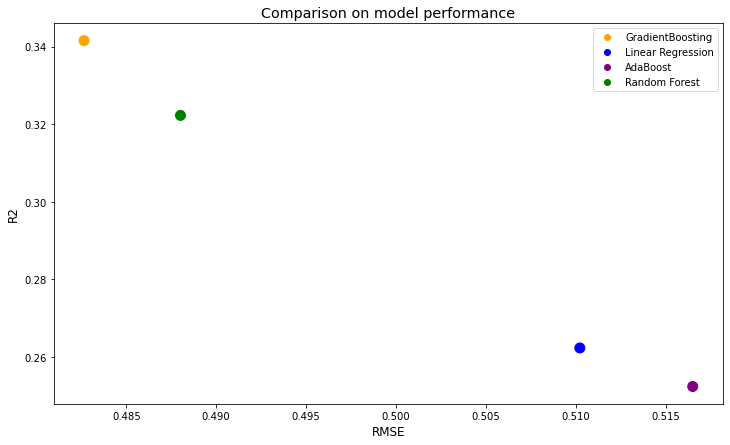

In [155]:
from matplotlib.colors import ListedColormap

rmses = [0.48264993736504785, 0.5102244767533842, 0.5165034343325131, 0.4880133594894239]
r2s = [0.3415363107771194, 0.2623074934143525, 0.25237353766643433, 0.3222507322159441]

plt.figure(figsize=(12,7))
plt.title("Comparison on model performance", size="x-large")
plt.xlabel("RMSE", size="large")
plt.ylabel("R2", size="large")

models = ["GradientBoosting", "Linear Regression", "AdaBoost", "Random Forest"]
colours = ListedColormap(['orange', 'blue', 'purple', 'green'])
scatter = plt.scatter(rmses, r2s, c=[0,1,2,3], cmap=colours, s=100)

plt.legend(handles=scatter.legend_elements()[0], labels=models)

### A glance into the predictions

In [338]:
preds_rounded[0:10]

array([[ 0., -0., -0., -0.,  0., -0., -0.,  0., -0.,  0.],
       [-0., -0.,  1.,  0., -0.,  0.,  1.,  1., -0., -0.],
       [ 0., -0.,  1., -0., -0., -0.,  0.,  0.,  0.,  0.],
       [ 1., -0.,  0., -0.,  0.,  1.,  1., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -0.,  1.,  0.],
       [ 0.,  0., -0., -0.,  0.,  1.,  1., -0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0.,  0., -0., -0.,  0.,  1., -0.,  1., -0.,  0.],
       [ 0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0., -0.],
       [ 0., -0.,  1., -0.,  0.,  0.,  0.,  1.,  1., -0.]])

In [340]:
predictions[1][2]

0.7686578647380296

In [337]:
y_test[0:10]

,0,1,2,3,4,5,6,7,8,9
8635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13739,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13320,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
13216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7322,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4152,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8622,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0
2595,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Supplemential: A classifier

In [345]:
y_cls = y.copy()

In [346]:
y_cls

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
14820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
14823,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
def make_binary(value):
    if value != 0 and value != 1:
        value = 1
    return value

In [348]:
for i in range(10):
    y_cls[str(i)] = list(map(make_binary, y_cls[str(i)]))
    
y_cls.describe()

,0,1,2,3,4,5,6,7,8,9
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.164115,0.170388,0.146981,0.133356,0.085464,0.252209,0.263069,0.234401,0.211062,0.132951
std,0.370392,0.375986,0.354099,0.339970,0.279580,0.434295,0.440314,0.423638,0.408076,0.339533
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [356]:
X_train, X_test, y_cls_train, y_cls_test = train_test_split(X, y_cls, test_size=0.1, random_state=13)

In [364]:
gbc = GradientBoostingClassifier(random_state=13)
multi_gbc = MultiOutputClassifier(gbc)
multi_gbc.fit(X_train, y_cls_train)

MultiOutputClassifier(estimator=GradientBoostingClassifier(random_state=13))

In [369]:
def multi_accuracy(y_true, y_pred):
    predictions_T = np.transpose(y_pred)
    scores = []
    for column in y_true.columns:
        accuracy = accuracy_score(y_true[column], predictions_T[int(column)])
        scores.append(accuracy)
    return scores

def multi_f1(y_true, y_pred):
    predictions_T = np.transpose(y_pred)
    scores = []
    for column in y_true.columns:
        f1 = f1_score(y_true[column], predictions_T[int(column)])
        scores.append(f1)
    return scores

def multi_roc_auc(y_true, y_pred):
    predictions_T = np.transpose(y_pred)
    scores = []
    for column in y_true.columns:
        ra = roc_auc_score(y_true[column], predictions_T[int(column)])
        scores.append(ra)
    return scores

In [365]:
predictions = multi_gbc.predict(X_test)

accuracy = multi_accuracy(y_cls_test, predictions)
avg_acc = avg_score(accuracy)
avg_acc

0.8849629130141604

In [368]:
f1 = multi_f1(y_cls_test, predictions)
avg_f1 = avg_score(f1)
avg_f1

0.5872345998105015

In [370]:
roc_auc = multi_roc_auc(y_cls_test, predictions)
avg_roc_auc = avg_score(roc_auc)
avg_roc_auc

0.7554652747439754